In [1]:
import os,gc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from kaggle_datasets import KaggleDatasets 
from sklearn.metrics import roc_auc_score

import tensorflow as tf 
import tensorflow.keras.applications.efficientnet as efn 
from tensorflow.keras.applications import ResNet152 

import albumentations as albu

# Configuration

In [2]:
LABELS = np.array(['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present'])

N_LABELS = 11 
DEBUG = False 
class CONFIG:
    version = 1
    epochs = 16
    imsize = (512,512)
    batchsize = 16
    seed = 123
    min_lr = 5e-6
    max_lr = 5e-4 
    lr = 1e-4 
    n_folds = 5
    tta = 2

if DEBUG:
    CONFIG.epochs = 1

## TPU 

In [3]:
def auto_select_accelerator():
    tpu_ok = False 
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tpu_ok = True
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    return strategy,tpu_ok

AUTO = tf.data.experimental.AUTOTUNE
strategy,tpu_ok = auto_select_accelerator()

Running on 1 replicas


In [4]:
def seed_tf(seed):
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

# DataLoader

In [5]:
#----------------------------------------------------------------------
## make dataset from tfrecord

## Decoder 
def decoder(img):
    img = tf.io.decode_jpeg(img,channels=3)
    img = tf.cast(img,tf.float32)
    img /= 255.0 
    img = tf.image.resize(img,CONFIG.imsize)
    return img

## Augmentation
def augmenter(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_hue(img,max_delta=0.01)
    img = tf.image.random_saturation(img,lower=0.70,upper=1.30) 
    img = tf.image.random_contrast(img,lower=0.80,upper=1.20)
    img = tf.image.random_brightness(img,max_delta=0.10)
    return img

def augmenter_with_label(img,label):
    return augmenter(img),label

## For TFRecord 
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([],tf.string),
        "ETT - Abnormal":tf.io.FixedLenFeature([],tf.int64),
        "ETT - Borderline":tf.io.FixedLenFeature([],tf.int64),
        "ETT - Normal":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Abnormal":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Borderline":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Incompletely Imaged":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Normal":tf.io.FixedLenFeature([],tf.int64),
        "CVC - Abnormal":tf.io.FixedLenFeature([],tf.int64),
        "CVC - Borderline":tf.io.FixedLenFeature([],tf.int64),
        "CVC - Normal":tf.io.FixedLenFeature([],tf.int64),
        "Swan Ganz Catheter Present":tf.io.FixedLenFeature([],tf.int64),
        'StudyInstanceUID': tf.io.FixedLenFeature([],tf.string),
    }
    example = tf.io.parse_single_example(example,LABELED_TFREC_FORMAT)
    # decoder 
    image = decoder(example["image"])
    targets = tf.stack([tf.cast(example[label],tf.float32) for label in LABELS])
    return image,targets

## Make Dataset from tfrecord
def make_dataset_from_tfrecord(paths,cache_dir=False,augment=False,repeat=False,shuffle=0):
    if cache_dir:
        os.makedirs(cache_dir,exist_ok=True)
    dset = tf.data.TFRecordDataset(paths)
    dset = dset.map(read_labeled_tfrecord,num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache_dir else dset 
    dset = dset.map(augmenter_with_label,num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset 
    dset = dset.batch(CONFIG.batchsize)
    dset = dset.prefetch(AUTO)
    return dset



#---------------------------------------------------------------------
## make dataset from original images 

## read and decoder 
def read_decoder(path):
    file_bytes = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file_bytes,channels=3)
    img = tf.cast(img,tf.float32)
    img /= 255.0 
    img = tf.image.resize(img,CONFIG.imsize)
    return img

def read_decoder_with_label(path,label):
    return read_decoder(path),label

## Augmentation
def augmenter(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_hue(img,max_delta=0.01)
    img = tf.image.random_saturation(img,lower=0.70,upper=1.30) 
    img = tf.image.random_contrast(img,lower=0.80,upper=1.20)
    img = tf.image.random_brightness(img,max_delta=0.10)
    return img

def augmenter_with_img(img,label):
    return augmenter(img),label

## Make Dataset 
def make_dataset(paths,labels=[],cache_dir=False,augment=False,repeat=False,shuffle=0):
    if cache_dir:
        os.makedirs(cache_dir,exist_ok=True)
    if len(labels) == 0:
        dset = tf.data.Dataset.from_tensor_slices(paths)
        dset = dset.map(read_decoder,num_parallel_calls=AUTO)
        dset = dset.cache(cache_dir) if cache_dir else dset 
        dset = dset.map(augmenter,num_parallel_calls=AUTO) if augment else dset
        dset = dset.repeat() if repeat else dset
        dset = dset.batch(CONFIG.batchsize)
        dset = dset.prefetch(AUTO)
        return dset
    else:
        dset = tf.data.Dataset.from_tensor_slices((paths,labels))
        dset = dset.map(read_decoder_with_label,num_parallel_calls=AUTO)
        dset = dset.cache(cache_dir) if cache_dir else dset 
        dset = dset.map(augmenter_with_label,num_parallel_calls=AUTO) if augment else dset
        dset = dset.repeat() if repeat else dset
        dset = dset.batch(CONFIG.batchsize)
        dset = dset.prefetch(AUTO)
        return dset
    

#----------------------------------------------------------------------------
## make dataset with albumentations (cannot use TPU)

## decoder 
def albu_decoder(img):
    img = tf.io.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,CONFIG.imsize)
    img = tf.cast(img,tf.uint8) 
    return img

## Augmentation 
transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.CLAHE(clip_limit=(1,100),p=1)
])

def albu_augmenter(image):
    aug_img = transform(image = image)["image"]
    aug_img = tf.cast(aug_img/255, tf.float32)
    aug_img = tf.image.resize(aug_img,CONFIG.imsize) 
    return aug_img

def process_data(image):
    aug_img = tf.numpy_function(func=albu_augmenter, inp=[image], Tout=tf.float32)
    aug_img.set_shape((*CONFIG.imsize,3))
    return aug_img

def process_data_with_label(image,label):
    return process_data(image),label

## Without Augmentation 
# CLAHEはuint8に対してしか作用できない. そのためdecode時に255で割ることができない. 
# なのでAugmentationしない場合も255で割る処理だけはする必要がある. 

def without_albu_augmenter(image):
    img = tf.cast(image/255, tf.float32)
    img = tf.image.resize(img,CONFIG.imsize) 
    return img

def without_albu_augmenter_with_label(image,label):
    return without_albu_augmenter_with_label(image),label   

## For TFRecord 
def read_labeled_tfrecord_with_albu(example):
    LABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([],tf.string),
        "ETT - Abnormal":tf.io.FixedLenFeature([],tf.int64),
        "ETT - Borderline":tf.io.FixedLenFeature([],tf.int64),
        "ETT - Normal":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Abnormal":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Borderline":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Incompletely Imaged":tf.io.FixedLenFeature([],tf.int64),
        "NGT - Normal":tf.io.FixedLenFeature([],tf.int64),
        "CVC - Abnormal":tf.io.FixedLenFeature([],tf.int64),
        "CVC - Borderline":tf.io.FixedLenFeature([],tf.int64),
        "CVC - Normal":tf.io.FixedLenFeature([],tf.int64),
        "Swan Ganz Catheter Present":tf.io.FixedLenFeature([],tf.int64),
        'StudyInstanceUID': tf.io.FixedLenFeature([],tf.string),
    }
    example = tf.io.parse_single_example(example,LABELED_TFREC_FORMAT)
    # decoder 
    image = albu_decoder(example["image"]) 
    targets = tf.stack([tf.cast(example[label],tf.float32) for label in LABELS])
    return image,targets

## Make Dataset with albumentation from tfrecord 
def make_dataset_with_albu_from_tfrecord(paths,cache_dir=False,augment=False,repeat=False,shuffle=0):
    if cache_dir:
        os.makedirs(cache_dir,exist_ok=True)
    dset = tf.data.TFRecordDataset(paths)
    dset = dset.map(read_labeled_tfrecord_with_albu,num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache_dir else dset 
    if augment:
        dset = dset.map(process_data_with_label,num_parallel_calls=AUTO)
    else:
        dset = dset.map(without_albu_augmenter_with_label,num_parallel_calls=AUTO) 
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset 
    dset = dset.batch(CONFIG.batchsize)
    dset = dset.prefetch(AUTO)
    return dset

#----------------------------------------------------------------------
## make dataset with albumentations from original images 

## read and decoder 
def albu_read_decoder(path):
    file_bytes = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file_bytes,channels=3)
    img = tf.image.resize(img,CONFIG.imsize)
    img = tf.cast(img,tf.uint8) 
    return img

def albu_read_decoder_with_label(path,label):
    return read_decoder(path),label

## Augmentation 
transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.CLAHE(clip_limit=(1,100),p=1)
])

def albu_augmenter(image):
    aug_img = transform(image = image)["image"]
    aug_img = tf.cast(aug_img/255, tf.float32)
    aug_img = tf.image.resize(aug_img,CONFIG.imsize) 
    return aug_img

def process_data(image):
    aug_img = tf.numpy_function(func=albu_augmenter, inp=[image], Tout=tf.float32)
    aug_img.set_shape((*CONFIG.imsize,3))
    return aug_img

def process_data_with_label(image,label):
    return process_data(image),label

## Without Augmentation 
# CLAHEはuint8に対してしか作用できない. そのためdecode時に255で割ることができない. 
# なのでAugmentationしない場合も255で割る処理だけはする必要がある. 

def without_albu_augmenter(image):
    img = tf.cast(image/255, tf.float32)
    img = tf.image.resize(img,CONFIG.imsize) 
    return img

def without_albu_augmenter_with_label(image,label):
    return without_albu_augmenter_with_label(image),label


## Make Dataset 
def make_dataset_with_albu(paths,labels=[],cache_dir=False,augment=False,repeat=False,shuffle=0):
    if cache_dir:
        os.makedirs(cache_dir,exist_ok=True)
    if len(labels) == 0:
        dset = tf.data.Dataset.from_tensor_slices(paths)
        dset = dset.map(albu_read_decoder,num_parallel_calls=AUTO)
        dset = dset.cache(cache_dir) if cache_dir else dset
        if augment:
            dset = dset.map(process_data,num_parallel_calls=AUTO)
        else:
            dset = dset.map(without_albu_augmenter,num_parallel_calls=AUTO)
        dset = dset.repeat() if repeat else dset
        dset = dset.batch(CONFIG.batchsize)
        dset = dset.prefetch(AUTO)
        return dset
    else:
        dset = tf.data.Dataset.from_tensor_slices((paths,labels)) 
        dset = dset.map(albu_read_decoder_with_label,num_parallel_calls=AUTO)
        dset = dset.cache(cache_dir) if cache_dir else dset 
        if augment:
            dset = dset.map(process_data_with_label,num_parallel_calls=AUTO)
        else:
            dset = dset.map(without_albu_augmenter_with_label,num_parallel_calls=AUTO)
        dset = dset.repeat() if repeat else dset
        dset = dset.batch(CONFIG.batchsize)
        dset = dset.prefetch(AUTO)
        return dset

# Show image

In [6]:
def view_image(dset,with_label=False,num=4):
    print(dset)
    if with_label:
        fig = plt.figure(figsize=(22, 22))
        image_label = next(iter(dset)) # first batch
        images = image_label[0]
        labels = image_label[1] 
        for i,(img,label) in enumerate(zip(images,labels)):
            if i == min(num,12):
                break 
            img = img.numpy()
            label = label.numpy()
            ax = fig.add_subplot(3,4,i+1,xticks=[],yticks=[])
            ax.imshow(img)
            ax.set_title(f"Label {label}")
        plt.show()
    else:
        fig = plt.figure(figsize=(22, 22))
        images = next(iter(dset)) # first batch 
        for i,img in enumerate(images):
            if i == min(num,12):
                break 
            img = img.numpy()
            ax = fig.add_subplot(3,4,i+1,xticks=[],yticks=[])
            ax.imshow(img)
        plt.show()

In [7]:
path_tfrecord = ["../input/ranzcr-clip-catheter-line-classification/train_tfrecords/00-1881.tfrec",
                 "../input/ranzcr-clip-catheter-line-classification/train_tfrecords/01-1881.tfrec"] 

df = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train.csv") 
path_org_image = "../input/ranzcr-clip-catheter-line-classification/train/" + df["StudyInstanceUID"] + ".jpg"
labels = df[LABELS].values 

In [8]:
dset_tf = make_dataset_from_tfrecord(path_tfrecord,augment=True,repeat=True,shuffle=0)
dset = make_dataset(path_org_image,labels=labels,cache_dir="kaggle/tf_cache",augment=True,repeat=True,shuffle=0)

dset_albu_tf = make_dataset_with_albu_from_tfrecord(path_tfrecord,augment=True) 
dset_albu = make_dataset_with_albu(path_org_image)

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 11)), types: (tf.float32, tf.float32)>


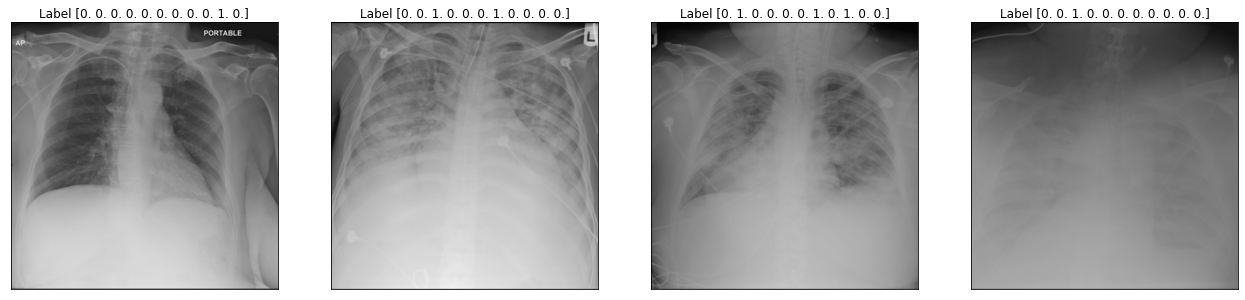

In [9]:
view_image(dset_tf,with_label=True)

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 11)), types: (tf.float32, tf.int64)>


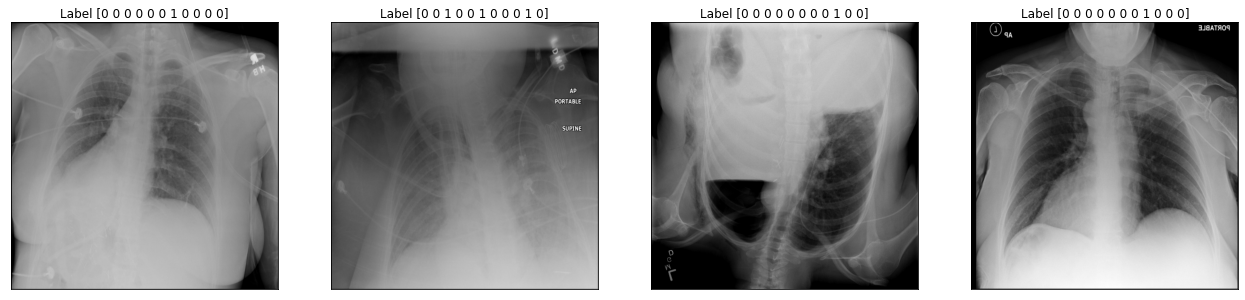

In [10]:
view_image(dset,with_label=True)

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 11)), types: (tf.float32, tf.float32)>


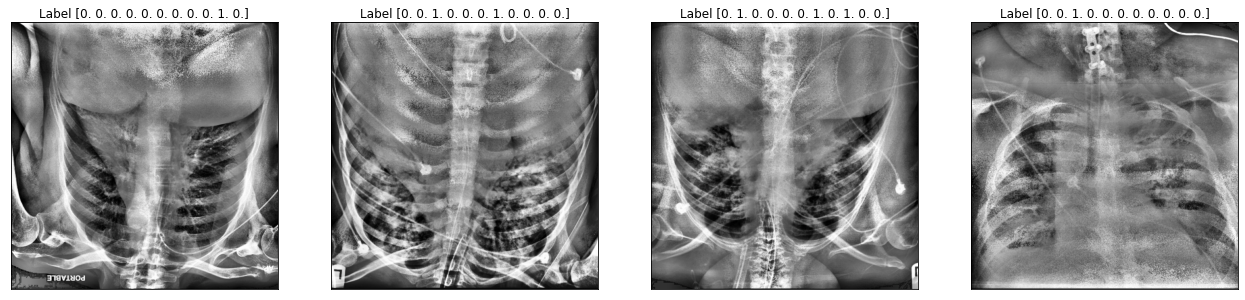

In [11]:
view_image(dset_albu_tf,with_label=True)

<PrefetchDataset shapes: (None, 512, 512, 3), types: tf.float32>


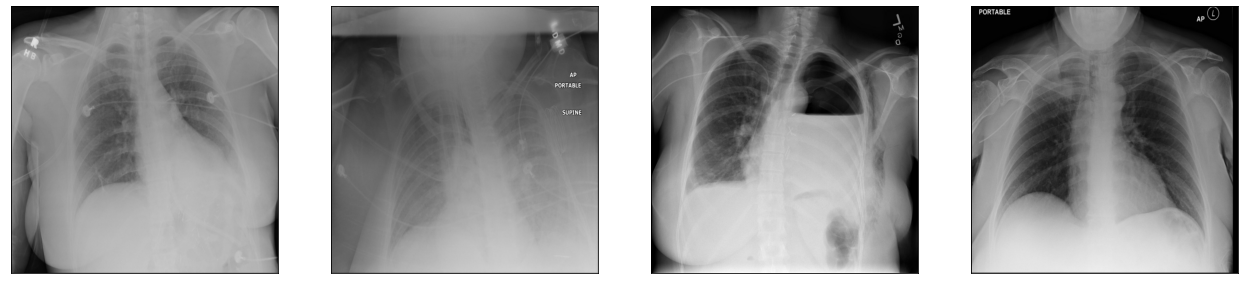

In [12]:
view_image(dset_albu,with_label=False)

# Models

In [13]:
def create_resnet152():
    with strategy.scope():
        model = tf.keras.Sequential([
            ResNet152(input_shape=(*CONFIG.imsize,3),
                                  weights="imagenet",
                                  include_top=False),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(N_LABELS,activation="sigmoid")
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.lr),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.AUC(multi_label=True,name="auc")])
    return model

def create_effb6():
    with strategy.scope():
        model = tf.keras.Sequential([
            efn.EfficientNetB6(input_shape=(*CONFIG.imsize,3),
                               weights="imagenet",
                               include_top=False,
                               drop_connect_rate=0.5),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(N_LABELS,activation="sigmoid")
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.lr),
                      loss=tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.50, gamma = 2.0),
                      metrics=[tf.keras.metrics.AUC(multi_label=True,name="auc")])
    return model

def create_multihead_model():
    with strategy.scope():
        inp = tf.keras.layers.Input(shape=(*CONFIG.imsize,3))
        x = ResNet152(weights="imagenet",include_top=False)(inp) 
        x = tf.keras.layers.GlobalAveragePooling2D()(x) 
        x = tf.keras.layers.BatchNormalization()(x)
        
        ett = tf.keras.layers.Dense(300)(x)
        ett = tf.keras.layers.Dropout(0.2)(ett)  
        ett = tf.keras.layers.Dense(3,activation="sigmoid")(ett)
        
        ngt = tf.keras.layers.Dense(300)(x)
        ngt = tf.keras.layers.Dropout(0.2)(ngt)
        ngt = tf.keras.layers.Dense(4,activation="sigmoid")(ngt)
        
        cvc = tf.keras.layers.Dense(300)(x)
        cvc = tf.keras.layers.Dropout(0.2)(cvc)
        cvc = tf.keras.layers.Dense(3,activation="sigmoid")(cvc)
        
        swan = tf.keras.layers.Dense(1,activation="sigmoid")(x)
        outs = tf.keras.layers.Concatenate(axis = 1)([ett,ngt,cvc,swan])
        
        model = tf.keras.models.Model(inputs = inp,outputs = outs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.lr),
                      loss=tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.50, gamma = 2.0),
                      metrics=[tf.keras.metrics.AUC(multi_label=True,name="auc")])
    return model

# Loss

In [14]:
pos_weight = tf.constant([0.99737393,0.96217133,0.75933251,0.99072566,0.98241532,
              0.90865273,0.84054117,0.89379384,0.71877805,0.29116112,
              0.97240967],tf.float32)
neg_weight = tf.constant([0.00262607,0.03782867,0.24066749,0.00927434,0.01758468,
              0.09134727,0.15945883,0.10620616,0.28122195,0.70883888,
              0.02759033],tf.float32)
mul = tf.multiply
def WeightedBinaryCrossentropy(y_true,y_pred):
    y_true = tf.cast(y_true,tf.float32)
    pos_loss = -mul(mul(      y_true,tf.math.log(    y_pred + 1e-13)),pos_weight) 
    neg_loss = -mul(mul(1.0 - y_true,tf.math.log(1 - y_pred + 1e-13)),neg_weight) 
    loss = tf.add(pos_loss,neg_loss)
    loss = tf.math.reduce_mean(loss,0)
    return tf.math.reduce_mean(loss,0)

# Other losses I tried
# tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.50, gamma = 2.0),
# tf.keras.losses.BinaryCrossentropy()

# Scheduler

In [15]:
def CosineAnnealing(epoch,lr):
    return CONFIG.min_lr + (CONFIG.max_lr - CONFIG.min_lr)*(1 + np.cos(epoch/CONFIG.epochs*np.pi))/2

# CV

In [16]:
def cv_tuner(load_dir,df,n_folds=CONFIG.n_folds):
    scores = []
    seed_tf(CONFIG.seed)
    
    if tpu_ok:
        path = KaggleDatasets().get_gcs_path(load_dir) # GCSPATH
    else:
        path = "../input/" + load_dir 
        
    for fold in range(n_folds):
        print("-"*50)
        train_paths = [path + f"/train_{CONFIG.imsize[0]}_{i}.tfrec" for i in range(n_folds) if i != fold]
        valid_path = path + f"/train_{CONFIG.imsize[0]}_{fold}.tfrec"
        
        if tpu_ok:
            train_dset = make_dataset_from_tfrecord(train_paths,augment=True,repeat=True,shuffle=2048)
            valid_dset = make_dataset_from_tfrecord(valid_path)
        else:
            train_dset = make_dataset_from_tfrecord(train_paths,cache_dir="kaggle/tf_cache",augment=True,repeat=True,shuffle=2048)
            valid_dset = make_dataset_from_tfrecord(valid_path,cache_dir="kaggle/tf_cache")
        
        # Callbacks 
        ckp_path = f"model_{CONFIG.version}_{fold}.h5"
        ckp = tf.keras.callbacks.ModelCheckpoint(ckp_path,save_best_only=True,monitor="val_auc",mode="max")
        # rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc",patience=1,factor=0.5,min_lr=1e-6,mode="max")
        rlr = tf.keras.callbacks.LearningRateScheduler(CosineAnnealing) 
        
        # Training 
        model = create_resnet152()
        steps_per_epoch = (fold_size[fold] + CONFIG.batchsize - 1)//CONFIG.batchsize
        history = model.fit(train_dset,
                            epochs=CONFIG.epochs,
                            batch_size=CONFIG.batchsize,
                            verbose=1,
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[ckp,rlr],
                            validation_data = valid_dset)
        pd.DataFrame(history.history).to_csv(f"history{CONFIG.version}_{fold}.csv")
        
        # TTA
        print("TTA...")
        model.load_weights(ckp_path) 
        valid_size = 30083 - fold_size[fold] 
        tta_dset = make_dataset(valid_path,augment=True,repeat=True)
        steps = (CONFIG.tta*valid_size + CONFIG.batchsize - 1)//CONFIG.batchsize 
        pred_tta = model.predict(tta_dset,
                                 steps = steps,
                                 batch_size=CONFIG.batchsize,
                                 verbose=1)[:CONFIG.tta*valid_size]
        pred = np.mean(pred_tta.reshape((valid_size,CONFIG.tta,N_LABELS),order = "F"),axis=1)
        pd.DataFrame(pred).to_csv(f"pred{CONFIG.version}_{fold}.csv")
        
        valid_labels = df[df.fold == fold][labels].values
        auc = mean_roc_auc(valid_labels,pred)
        
        print(f"FOLD : AUC {auc}")
        scores.append(auc)
        del train_dset,valid_dset,model,history,train_paths,valid_path
        gc.collect()
        

    scores = np.array(scores)
    print(f"SCORES : {scores.mean()}")

In [17]:
df = pd.read_csv("../input/ranzcr-sgkf-data/train_folds.csv") 
fold_size = [24080,24042,24092,24065,24053]
#cv_tuner("ranzcr-512-sgkf",df)